In [1]:
from koopman_probabilistic import *
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt

from scipy.stats import norm, skewnorm

In [27]:
zone_name = "ISO NE CA"

In [49]:
import json

with open("GEFCom2017//COVID//COVIDdemandApr2020-2021.json") as f:
    all_data = json.loads(f.read())
    
# x = np.transpose(np.array([all_data["ISONE CA"]["DEMAND"], all_data["ISONE CA"]["DewPnt"], all_data["ISONE CA"]["DryBulb"]], dtype=np.float64))
# all_zones = []
# all_temps = []
# # ['ISONE CA', 'ME', 'RI', 'VT', 'CT', 'NH', 'SEMASS', 'WCMASS', 'NEMASSBOST']
# for zone in all_data.keys():
#     all_zones.append(all_data[zone]["DEMAND"])
#     all_temps.append(all_data[zone]["DryBulb"])
# x = np.transpose(np.array(all_zones, dtype=np.float64))
x = np.transpose(np.array([all_data[zone_name]["RT_Demand"]], dtype=np.float64))

In [55]:
print(all_data[zone_name].keys())
print(all_data[zone_name]["Date"][0:24])

dict_keys(['Date', 'Hr_End', 'DA_Demand', 'RT_Demand', 'DA_LMP', 'DA_EC', 'DA_CC', 'DA_MLC', 'RT_LMP', 'RT_EC', 'RT_CC', 'RT_MLC', 'Dry_Bulb', 'Dew_Point', 'System_Load', 'Reg_Service_Price', 'Reg_Capacity_Price', 'Min_5min_RSP', 'Max_5min_RSP', 'Min_5min_RCP', 'Max_5min_RCP'])
['2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00', '2020-04-01 00:00:00']


In [50]:
x_original = x
mean = np.mean(x, axis=0)
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = (x - np.matlib.repmat(mean, x.shape[0], 1)) / np.matlib.repmat(rnge, x.shape[0], 1)
print("x", x.shape)

x (7344, 1)


In [51]:
data_name = "COVID_" + zone_name

train_through = 366 * 24 - 2184  # leap year. covid started 2184 hours into the year
train_start = 0
delay = 0  # 52 * 24  # 1.5 to 2 month gap, then 1 month forecast
x = x[train_start:]
predict_through = train_through + 24 * 31 + delay  
x = x[:predict_through]
xt = x[:train_through, :]

num_freqs = [4, 4, 4]
# num_freqs = [4, 4]
num_fourier = 4
mu_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}mu.npy"
sigma_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}sigma.npy"
alpha_file = "forecasts//" + data_name + f"trained{train_start}-{train_through}_{num_freqs}alpha.npy"
print("x", x.shape)
print("xt", xt.shape)

x (7344, 1)
xt (6600, 1)


In [73]:
model = AlternatingSkewNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=512)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [74]:
k.find_fourier_omegas(xt, hard_code=[24, 168, 24 * 365.25 / 12, 24 * 365.25])

tensor([0.2618, 0.0374, 0.0086, 0.0007])

In [103]:
k.fit(xt, iterations=200, interval=10, verbose=True, cutoff=0, weight_decay=1e-10000, lr_theta=3e-4, lr_omega=1e-10, num_slices=None);

Iteration  0
tensor([  24.0000,  168.0000,  730.4999, 8778.1494,   24.0000,  168.0000,
         730.4999, 8789.2559,   24.0000,  168.0000,  730.4999, 8760.8027])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1494,   24.0000,  168.0000,
         730.4999, 8789.2559,   24.0000,  168.0000,  730.4999, 8760.8027],
       grad_fn=<MulBackward0>)
Loss:  -1.4709413003825498
Iteration  1
tensor([  24.0000,  168.0000,  730.4999, 8778.1494,   24.0000,  168.0000,
         730.4999, 8789.2559,   24.0000,  168.0000,  730.4999, 8760.8027])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1494,   24.0000,  168.0000,
         730.4999, 8789.2559,   24.0000,  168.0000,  730.4999, 8760.8027],
       grad_fn=<MulBackward0>)
Loss:  -1.4710148594742638
Iteration  2
tensor([  24.0000,  168.0000,  730.4999, 8778.1494,   24.0000,  168.0000,
         730.4999, 8789.2559,   24.0000,  168.0000,  730.4999, 8760.8027])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 87

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1543,   24.0000,  168.0000,
         730.4999, 8789.2520,   24.0000,  168.0000,  730.4999, 8760.8018],
       grad_fn=<MulBackward0>)
Loss:  -1.4724915232084774
Iteration  22
tensor([  24.0000,  168.0000,  730.4999, 8778.1543,   24.0000,  168.0000,
         730.4999, 8789.2520,   24.0000,  168.0000,  730.4999, 8760.8018])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1543,   24.0000,  168.0000,
         730.4999, 8789.2480,   24.0000,  168.0000,  730.4999, 8760.8008],
       grad_fn=<MulBackward0>)
Loss:  -1.472565438554642
Iteration  23
tensor([  24.0000,  168.0000,  730.4999, 8778.1543,   24.0000,  168.0000,
         730.4999, 8789.2480,   24.0000,  168.0000,  730.4999, 8760.8008])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1543,   24.0000,  168.0000,
         730.4999, 8789.2441,   24.0000,  168.0000,  730.4999, 8760.7998],
       grad_fn=<MulBackward0>)
Loss:  -1.47263970791906

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1689,   24.0000,  168.0000,
         730.4999, 8789.1611,   24.0000,  168.0000,  730.4999, 8760.7852],
       grad_fn=<MulBackward0>)
Loss:  -1.4741295127910226
Iteration  44
tensor([  24.0000,  168.0000,  730.4999, 8778.1689,   24.0000,  168.0000,
         730.4999, 8789.1611,   24.0000,  168.0000,  730.4999, 8760.7852])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1699,   24.0000,  168.0000,
         730.4999, 8789.1582,   24.0000,  168.0000,  730.4999, 8760.7852],
       grad_fn=<MulBackward0>)
Loss:  -1.4742046254177776
Iteration  45
tensor([  24.0000,  168.0000,  730.4999, 8778.1699,   24.0000,  168.0000,
         730.4999, 8789.1582,   24.0000,  168.0000,  730.4999, 8760.7852])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1709,   24.0000,  168.0000,
         730.4999, 8789.1543,   24.0000,  168.0000,  730.4999, 8760.7842],
       grad_fn=<MulBackward0>)
Loss:  -1.4742795257529

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1865,   24.0000,  168.0000,
         730.4999, 8789.0752,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.475792223203614
Iteration  66
tensor([  24.0000,  168.0000,  730.4999, 8778.1865,   24.0000,  168.0000,
         730.4999, 8789.0752,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1875,   24.0000,  168.0000,
         730.4999, 8789.0713,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.4758684063899545
Iteration  67
tensor([  24.0000,  168.0000,  730.4999, 8778.1875,   24.0000,  168.0000,
         730.4999, 8789.0713,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.1904,   24.0000,  168.0000,
         730.4999, 8789.0664,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.47594475978423

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.2236,   24.0000,  168.0000,
         730.4999, 8788.9805,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.477486218814461
Iteration  88
tensor([  24.0000,  168.0000,  730.4999, 8778.2236,   24.0000,  168.0000,
         730.4999, 8788.9805,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.2256,   24.0000,  168.0000,
         730.4999, 8788.9766,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.4775641218307143
Iteration  89
tensor([  24.0000,  168.0000,  730.4999, 8778.2256,   24.0000,  168.0000,
         730.4999, 8788.9766,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.2275,   24.0000,  168.0000,
         730.4999, 8788.9727,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.47764191798258

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.2637,   24.0000,  168.0000,
         730.4999, 8788.9014,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.4792154992979318
Iteration  110
tensor([  24.0000,  168.0000,  730.4999, 8778.2637,   24.0000,  168.0000,
         730.4999, 8788.9014,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.2646,   24.0000,  168.0000,
         730.4999, 8788.8984,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.4792947441963231
Iteration  111
tensor([  24.0000,  168.0000,  730.4999, 8778.2646,   24.0000,  168.0000,
         730.4999, 8788.8984,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.2666,   24.0000,  168.0000,
         730.4999, 8788.8955,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.47937433161

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.2998,   24.0000,  168.0000,
         730.4999, 8788.8516,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.4809779703905088
Iteration  132
tensor([  24.0000,  168.0000,  730.4999, 8778.2998,   24.0000,  168.0000,
         730.4999, 8788.8516,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.3008,   24.0000,  168.0000,
         730.4999, 8788.8486,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.481058785777062
Iteration  133
tensor([  24.0000,  168.0000,  730.4999, 8778.3008,   24.0000,  168.0000,
         730.4999, 8788.8486,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.3027,   24.0000,  168.0000,
         730.4999, 8788.8467,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.481139611351

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.3311,   24.0000,  168.0000,
         730.4999, 8788.8076,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.4827683356409762
Iteration  154
tensor([  24.0000,  168.0000,  730.4999, 8778.3311,   24.0000,  168.0000,
         730.4999, 8788.8076,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.3330,   24.0000,  168.0000,
         730.4999, 8788.8057,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.482850139117769
Iteration  155
tensor([  24.0000,  168.0000,  730.4999, 8778.3330,   24.0000,  168.0000,
         730.4999, 8788.8057,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.3340,   24.0000,  168.0000,
         730.4999, 8788.8047,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.482932207053

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.3672,   24.0000,  168.0000,
         730.4999, 8788.7764,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.4845775836887924
Iteration  176
tensor([  24.0000,  168.0000,  730.4999, 8778.3672,   24.0000,  168.0000,
         730.4999, 8788.7764,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.3691,   24.0000,  168.0000,
         730.4999, 8788.7744,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.484660125650216
Iteration  177
tensor([  24.0000,  168.0000,  730.4999, 8778.3691,   24.0000,  168.0000,
         730.4999, 8788.7744,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.3711,   24.0000,  168.0000,
         730.4999, 8788.7725,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.484742717380

Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.4277,   24.0000,  168.0000,
         730.4999, 8788.7314,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.486396075228093
Iteration  198
tensor([  24.0000,  168.0000,  730.4999, 8778.4277,   24.0000,  168.0000,
         730.4999, 8788.7314,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.4307,   24.0000,  168.0000,
         730.4999, 8788.7295,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.4864788412045868
Iteration  199
tensor([  24.0000,  168.0000,  730.4999, 8778.4307,   24.0000,  168.0000,
         730.4999, 8788.7295,   24.0000,  168.0000,  730.4999, 8760.7744])
Setting periods to tensor([  24.0000,  168.0000,  730.4999, 8778.4326,   24.0000,  168.0000,
         730.4999, 8788.7266,   24.0000,  168.0000,  730.4999, 8760.7744],
       grad_fn=<MulBackward0>)
Loss:  -1.486561567434

In [104]:
params = k.predict(predict_through)
mu_hat, sigma_hat, a_hat = params
np.save(mu_file, mu_hat)
np.save(sigma_file, sigma_hat)
np.save(alpha_file, a_hat)
# params = k.predict(predict_through)
# mu_hat, sigma_hat = params
# np.save(mu_file, mu_hat)
# np.save(sigma_file, sigma_hat)

<IPython.core.display.Javascript object>


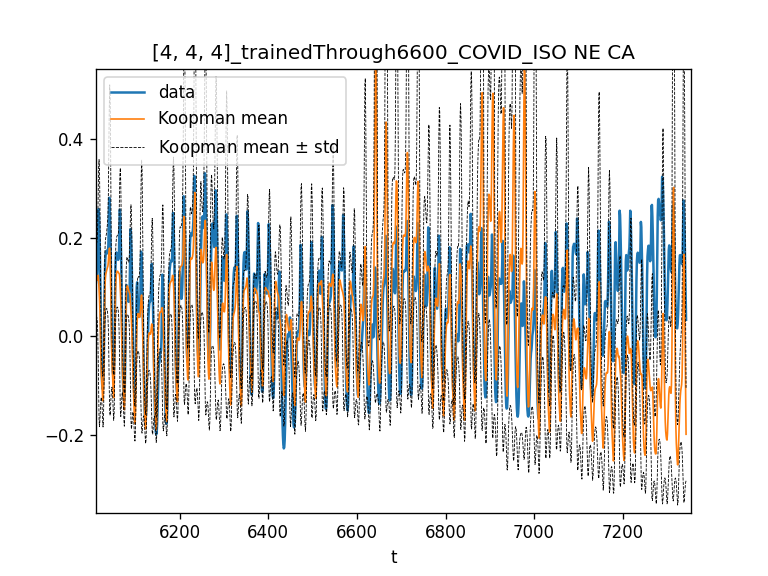

In [105]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure()
    # plt.scatter(np.arange(-slc), x[slc:], label="data")
    plt.plot(x[:predict_through, dim], label="data")
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
#     plt.plot(a_hat[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
#     plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")

    # plt.plot(mu_vec[slc:], label="real mu")
    # plt.plot(mu_hat[slc:, 0], label="koopman mu")
    # plt.legend()
    # plt.show()
    #
    # plt.plot(sigma_vec[slc:], label="real sigma")
    #     plt.plot(3*sigma_hat[:, dim], label="koopman $3\sigma$", linewidth=0.7)
    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


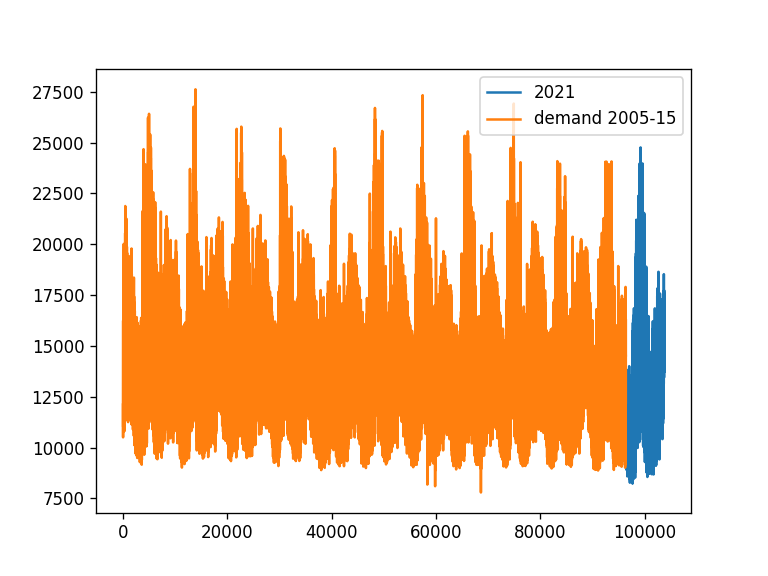

In [102]:
plt.figure()
plt.plot(np.arange(len(oldx), len(oldx) + len(x_original)), x_original, label="2021")
plt.plot(oldx, label="demand 2005-15")
plt.legend()
plt.show()

In [106]:
print("actual overall mean:", 0, " predicted mean:", np.mean(mean_hat[:train_through]))

actual overall mean: 0  predicted mean: -0.048109796


In [107]:
"mean of a_hat", np.mean(a_hat)

('mean of a_hat', 1.9553598)

In [108]:
def normal_pdf(mu, sigma, x):
    return np.exp(-(x - mu)**2 / (2 * sigma**2))/((2 * np.pi * sigma**2)**0.5)

In [109]:
z_scores = ((x[:train_through] - mean_hat[:train_through]) / std_hat[:train_through])
# z_scores = ((x[train_through:predict_through] - mean_hat[train_through:]) / std_hat[train_through:])[:8760, 0]
# z_scores /= np.std(z_scores)
z_hist, bin_edges = np.histogram(z_scores, bins=40, density=True)
z_axis = (bin_edges[1:] + bin_edges[:-1]) / 2

In [110]:
print(np.std(z_scores))
np.mean(z_scores)

0.9756564285409445


0.17669800194145704

<IPython.core.display.Javascript object>


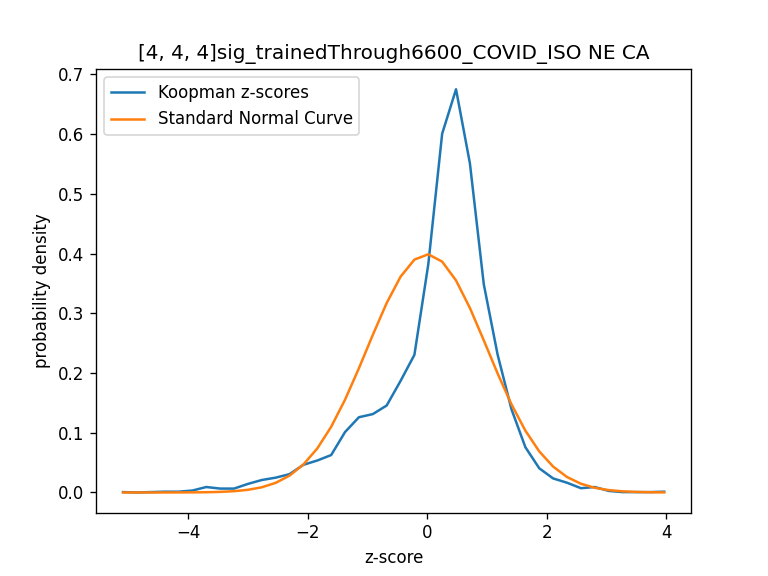

In [111]:
plt.figure()
plt.plot(z_axis, z_hist, label="Koopman z-scores")
plt.plot(z_axis, normal_pdf(0, 1, z_axis), label="Standard Normal Curve")
plt.title(f"{num_freqs}sig_trainedThrough{train_through}_" + data_name)
plt.xlabel("z-score")
plt.ylabel("probability density")
plt.legend()

In [112]:
mu_hat -= np.mean(mean_hat[:train_through])

# Pinball Loss

In [113]:
def skew_pinball_loss(data, mus, sigmas, alphas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = skewnorm.ppf(q, alphas[i], loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [114]:
def normal_pinball_loss(data, mus, sigmas, quantiles=range(10, 100, 10)):
    loss = 0
    for i in range(len(data)):
        for q in quantiles:
            q = q / 100
            quant_pred = norm.ppf(q, loc=mus[i], scale=sigmas[i])
            if quant_pred > data[i]:
                loss += (quant_pred - data[i]) * (1 - q)
            else:
                loss += (data[i] - quant_pred) * q
    return loss / (len(data) * len(quantiles))

In [116]:
test_start = train_through + delay
# Skew Normal Distribution rescaling
sigh, ah = sigma_hat[test_start: predict_through], a_hat[test_start: predict_through]
delta = ah / (1 + ah ** 2) ** 0.5
muh = mu_hat[test_start: predict_through] * rnge + (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
muh = muh + mean - (rnge - 1) * delta * sigh * (2 / np.pi) ** 0.5
sigh = sigh * rnge
mean_hat = model.mean([muh, sigh, ah])
std_hat = model.std([muh, sigh, ah])

# # Normal Distribution
# sigh = sigma_hat[test_start: predict_through] * rnge
# muh = mu_hat[test_start: predict_through] * rnge + mean
# mean_hat = model.mean([muh, sigh])
# std_hat = model.std([muh, sigh])

plt.figure()
plt.plot(x_original[train_start:][test_start: predict_through])
plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)
# plt.plot(ah[:, dim], color="red", linewidth=0.3, label="Koopman $\\alpha$")
# plt.plot(std_hat[:, dim], color="green", linewidth=0.7, label="Koopman std")
plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
plt.xlabel("t")
plt.legend()
plt.show()

<IPython.core.display.Javascript object>

In [98]:
# loss = normal_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh)
loss = skew_pinball_loss(x_original[train_start:][test_start: predict_through], muh, sigh, ah)
print(loss)

[727.72741861]


In [ ]:
import vanilla_benchmark

vanilla_losses = vanilla_benchmark.get_losses(plot=False)
print(vanilla_losses)

In [25]:
1 - loss/vanilla_losses[zone_name]

# with 52 day gap between training and testing
# 1 - loss / 84.2  # WCMASS +25%
# 1 - loss / 122.8  # NEMASSBOST 39.4%
# 1 - loss / 596  # ISONE 19.4%
# VT: +9.2%
# (old--Monday=0) {'ISONE CA': 523.7428637110866, 'ME': 58.71157246544602, 'RI': 36.73051071209801, 'VT': 22.977155005752657, 'CT': 141.30040329213762, 'NH': 63.25224646477936, 'SEMASS': 65.42717786334023, 'WCMASS': 70.82418918073226, 'NEMASSBOST': 110.09485925971588}


array([-0.59346956])

In [29]:
import os

folder = ".\\forecasts\GEFComFirstQualTest"
a_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]alpha.npy"))
mu_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]mu.npy"))
sigma_hat = np.load(os.path.join(folder, "WCMASStrained-17520-8760_[6, 6, 6]sigma.npy"))

In [22]:
a = torch.tensor([0, 1])

In [25]:
a = a[:, None]

In [27]:
torch.repeat_interleave(a, 3, 1)

tensor([[0, 0, 0],
        [1, 1, 1]])

In [26]:
a.shape

torch.Size([2, 1])

In [1]:
import vanilla_benchmark

ModuleNotFoundError: No module named 'vanilla_benchmark'